# Checking the Annotation Results

Understanding what SAE feature directions represent and how they could be useful involves an annotation process. In natural language, this is relatively straightforward because we can inherently understand strings of tokens in English if we speak that language fluently. In order to accomplish this with the language of biology, we can start to translate this by comparing the activations with known biological signals. In this case, we use NCBI regulatory element tracks from the UCSC Genome Browser. See metadata from the download below:
```
Source: UCSC Table Browser 
URL: https://genome.ucsc.edu/cgi-bin/hgTables
Clade: Mammal
Genome: Human
Assembly: GRCh38/hg38
Group: Regulation
Track: RefSeq Func Elems
Table: refSeqFuncElems
Region: Genome
```

The data we're looking at represents pearson product-moment correlations, and normalized cross-correlations between SAE activations and these regulatory elements across tokens in a sequence. In order to align the signals, we take each line from the bed file, pull the sequence and about 100 bases upstream/downstream from the start position, and chunk it into 6000 base (6 kb) segments so that each one fits into the context window. The presence or absence of the regulatory element track in question is represented as a one or a zero, averaged over the length of the token. The scripts used to do the basic computations can be found in the `hsg/featureanalysis/` folder of this repository.

Because the context window is up to 6 kb long, and each vector in the `NTv2-500m-humanref` model is originally 1280 positions in length, this means that we generally cannot look at every feature and every track in depth. SAEs are configured to expand the latent space, thus, we have 10,240 features with an expansion factor of 8, and our largest is 40,960 features with an expansion factor of 32. We calculated correlations for each feature against each NCBI regulatory element track, along with descriptive statistics for those correlations over each of the 6 kb fragments. The top 5 features are recorded in csv files for each layer.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import storage

In [2]:
from matplotlib import font_manager

fira_sans_regular = font_manager.FontProperties("~/fonts/FiraSansRegular.ttf")
fira_sans_semibold = font_manager.FontProperties("~/fonts/FiraSansSemiBold.ttf")

darkgreen = '#9BC184'
midgreen = '#C2D6A4'
lightgreen = '#E7E5CB'
colors = [lightgreen, midgreen, darkgreen, midgreen, lightgreen]

darkgrey = "#525252"

In [3]:
client = storage.Client()
bucket = client.get_bucket('hidden-state-genomics')
blob = bucket.blob("regelannotations/ef8/layer_23")

directory = {
    "ef8": [f"layer_{i}" for i in range(24)],
    "ef16": [f"layer_{i}" for i in range(24)],
    "ef32": [f"layer_{i}" for i in range(24)],
}

## General Feature Extraction Per Layer

To visualize how well features are extracted with masked language modeling in NTv2, we constructed several ridgeline plots of the best correlated features for each track and their correlation values. In each chart below, the overall distribution is shown as a density plot with quartiles (2.5%, 10%, 25%, 75%, 90%, 97.5%) shown in a green shaded color bar. The black dotted line indicates the average top feature correlation across all layers, while the dotted red line indicates the average top feature correlation for that particular layer.

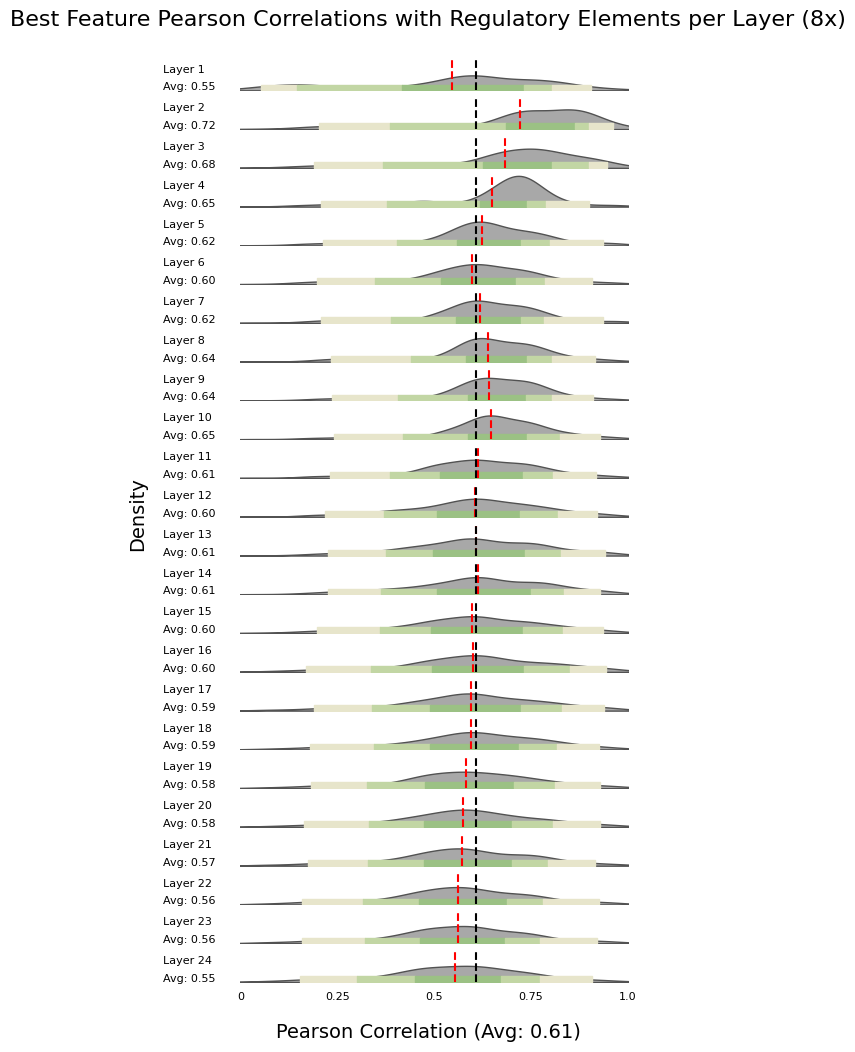

In [4]:
# ef8
ridgeline_data = []
for layer in directory["ef8"]:
    blob = bucket.blob(f"regelannotations/ef8/{layer}")
    csv_file = blob.open("r")
    df = pd.read_csv(csv_file)
    ridgeline_data.append(df["f1_mean"])


# global mean
global_mean = pd.concat(ridgeline_data).mean()


# Plotting
fig, axs = plt.subplots(nrows=len(ridgeline_data), ncols=1, figsize=(5, 12), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle(
    "Best Feature Pearson Correlations with Regulatory Elements per Layer (8x)",
    fontsize=16,
    #fontproperties=fira_sans_semibold,
    y = 0.92
)
fig.supxlabel(
    f"Pearson Correlation (Avg: {global_mean:.2f})",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    y = 0.06
)
fig.supylabel(
    "Density",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    x = -0.1  # move y-label slightly left
)

# construct the ridgeline plot
for i, data in enumerate(ridgeline_data):
    sns.kdeplot(data, ax=axs[i], fill=True, alpha=0.5, color=darkgrey)

    # relative averages
    mean = data.mean()
    axs[i].axvline(mean, color='red', linestyle='--', label='Mean')
    axs[i].axvline(global_mean, color="black", linestyle='--', label='Global Mean')

    # add some annotations
    axs[i].text(
        -0.2, 2.5,
        f"Layer {i+1}",
        ha="left",
        fontsize=8,
    )

    axs[i].text(
        -0.2, 0,
        f"Avg: {mean:.2f}",
        ha="left",
        fontsize=8,
    )

    # quantiles
    quantiles = np.percentile(data, [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        axs[i].fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            0, # max y=0
            0.8, # max y=0.8
            color=colors[j]
        )

    # x axis scale for last ax
    if i == 23:
        values = [0, 0.25, 0.5, 0.75, 1.0]
        for value in values:
            axs[i].text(
                value, -2.5,
                f'{value}',
                ha='center',
                fontsize=8
            )

    axs[i].set_xlim(0, 1)
    axs[i].set_axis_off()

plt.show()

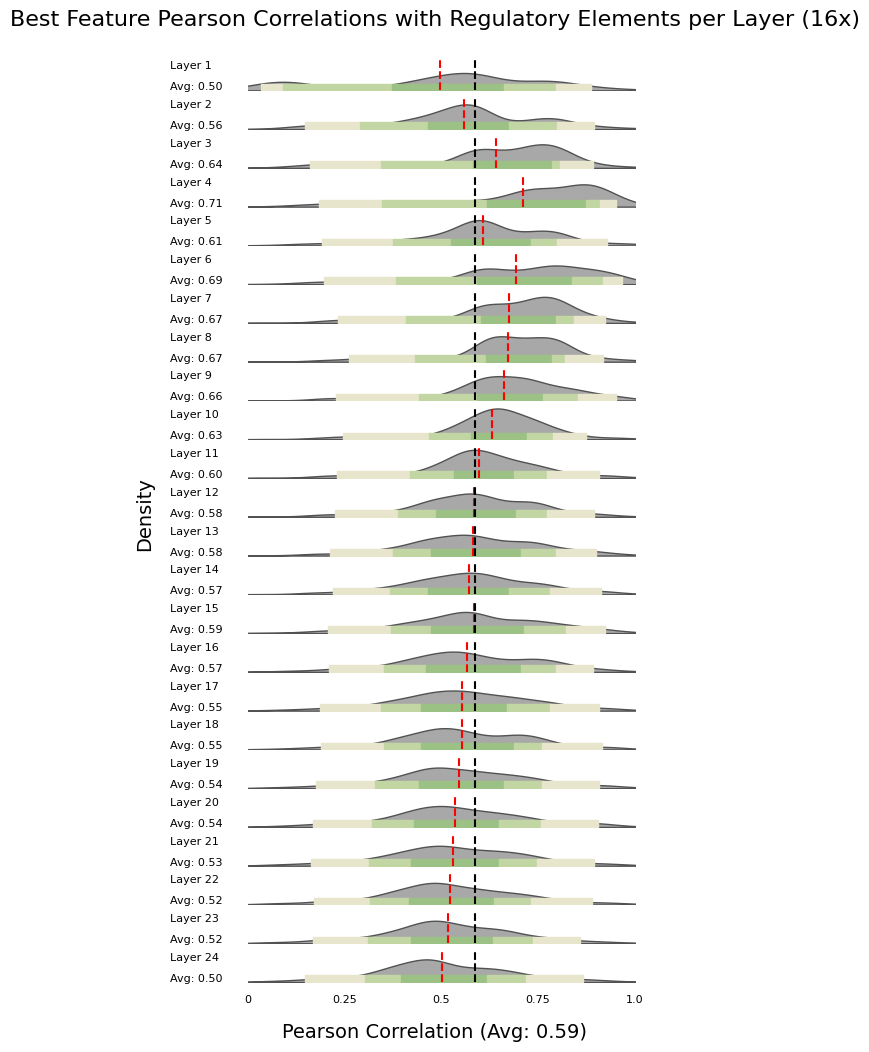

In [5]:
# ef16
ridgeline_data = []
for layer in directory["ef16"]:
    blob = bucket.blob(f"regelannotations/ef16/{layer}")
    csv_file = blob.open("r")
    df = pd.read_csv(csv_file)
    ridgeline_data.append(df["f1_mean"])


# global mean
global_mean = pd.concat(ridgeline_data).mean()


# Plotting
fig, axs = plt.subplots(nrows=len(ridgeline_data), ncols=1, figsize=(5, 12), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle(
    "Best Feature Pearson Correlations with Regulatory Elements per Layer (16x)",
    fontsize=16,
    #fontproperties=fira_sans_semibold,
    y = 0.92
)
fig.supxlabel(
    f"Pearson Correlation (Avg: {global_mean:.2f})",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    y = 0.06
)
fig.supylabel(
    "Density",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    x = -0.1  # move y-label slightly left
)

# construct the ridgeline plot
for i, data in enumerate(ridgeline_data):
    sns.kdeplot(data, ax=axs[i], fill=True, alpha=0.5, color=darkgrey)

    # relative averages
    mean = data.mean()
    axs[i].axvline(mean, color='red', linestyle='--', label='Mean')
    axs[i].axvline(global_mean, color="black", linestyle='--', label='Global Mean')

    # add some annotations
    axs[i].text(
        -0.2, 2.5,
        f"Layer {i+1}",
        ha="left",
        fontsize=8,
    )

    axs[i].text(
        -0.2, 0,
        f"Avg: {mean:.2f}",
        ha="left",
        fontsize=8,
    )

    # quantiles
    quantiles = np.percentile(data, [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        axs[i].fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            0, # max y=0
            0.8, # max y=0.8
            color=colors[j]
        )

    # x axis scale for last ax
    if i == 23:
        values = [0, 0.25, 0.5, 0.75, 1.0]
        for value in values:
            axs[i].text(
                value, -2.5,
                f'{value}',
                ha='center',
                fontsize=8
            )

    axs[i].set_xlim(0, 1)
    axs[i].set_axis_off()

plt.show()

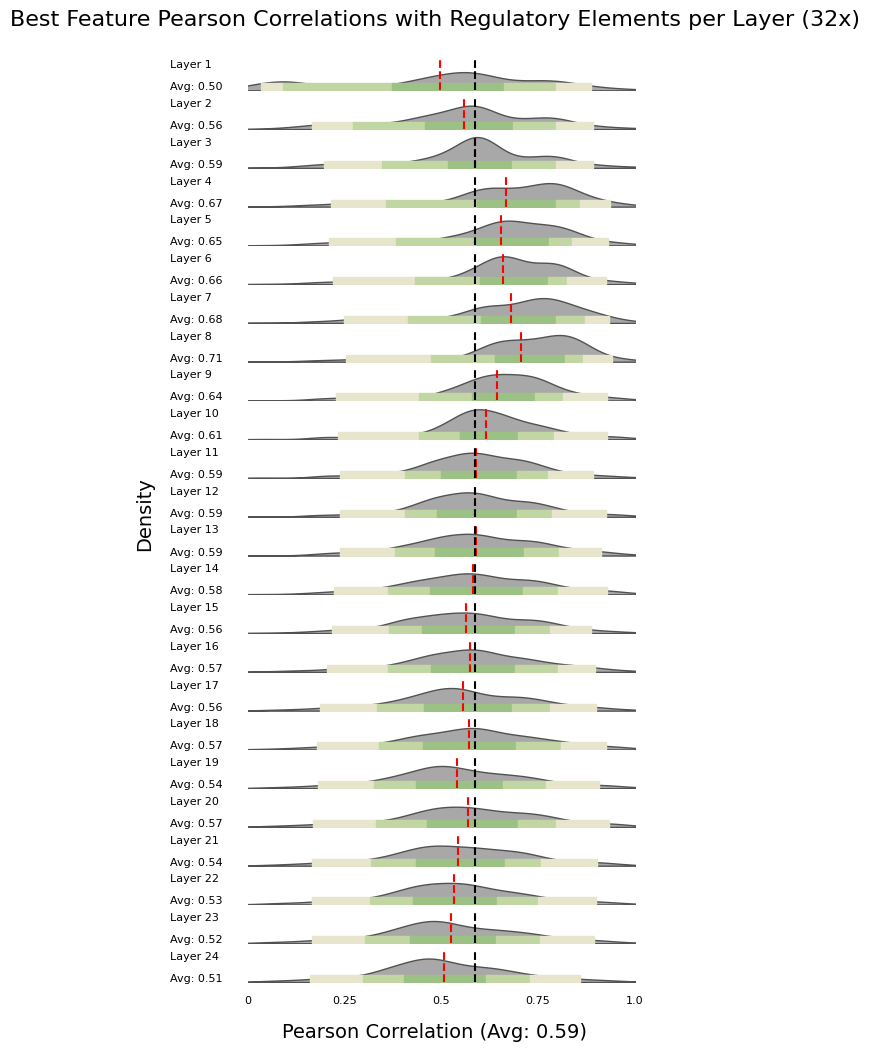

In [6]:
# ef32
ridgeline_data = []
for layer in directory["ef32"]:
    blob = bucket.blob(f"regelannotations/ef32/{layer}")
    csv_file = blob.open("r")
    df = pd.read_csv(csv_file)
    ridgeline_data.append(df["f1_mean"])


# global mean
global_mean = pd.concat(ridgeline_data).mean()


# Plotting
fig, axs = plt.subplots(nrows=len(ridgeline_data), ncols=1, figsize=(5, 12), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle(
    "Best Feature Pearson Correlations with Regulatory Elements per Layer (32x)",
    fontsize=16,
    #fontproperties=fira_sans_semibold,
    y = 0.92
)
fig.supxlabel(
    f"Pearson Correlation (Avg: {global_mean:.2f})",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    y = 0.06
)
fig.supylabel(
    "Density",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    x = -0.1  # move y-label slightly left
)

# construct the ridgeline plot
for i, data in enumerate(ridgeline_data):
    sns.kdeplot(data, ax=axs[i], fill=True, alpha=0.5, color=darkgrey)

    # relative averages
    mean = data.mean()
    axs[i].axvline(mean, color='red', linestyle='--', label='Mean')
    axs[i].axvline(global_mean, color="black", linestyle='--', label='Global Mean')

    # add some annotations
    axs[i].text(
        -0.2, 2.5,
        f"Layer {i+1}",
        ha="left",
        fontsize=8,
    )

    axs[i].text(
        -0.2, 0,
        f"Avg: {mean:.2f}",
        ha="left",
        fontsize=8,
    )

    # quantiles
    quantiles = np.percentile(data, [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        axs[i].fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            0, # max y=0
            0.8, # max y=0.8
            color=colors[j]
        )

    # x axis scale for last ax
    if i == 23:
        values = [0, 0.25, 0.5, 0.75, 1.0]
        for value in values:
            axs[i].text(
                value, -2.5,
                f'{value}',
                ha='center',
                fontsize=8
            )

    axs[i].set_xlim(0, 1)
    axs[i].set_axis_off()

plt.show()

## Normalized Cross Correlation per Layer

Normalized Cross Correlation is a signal processing statistic that attempts to account for variance in amplitude and phase shifts (i.e. feature activates downstream from its trigger) between two signals. This provides a more sensitive correlation metric for comparison, which, can provide an indication of low-activity features that nonetheless track meaningful genomic concepts.

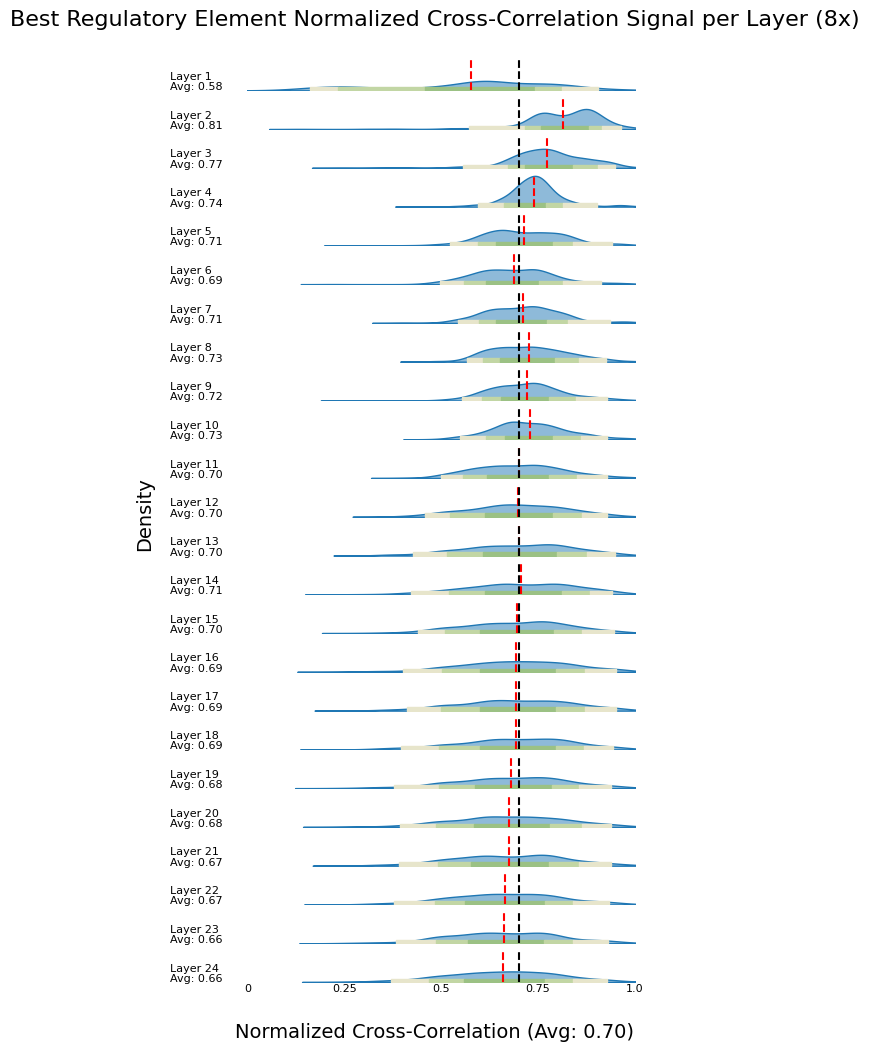

In [7]:
# ef8
ridgeline_data = []
for layer in directory["ef8"]:
    blob = bucket.blob(f"regelannotations/ef8/{layer}")
    csv_file = blob.open("r")
    df = pd.read_csv(csv_file)
    ridgeline_data.append(df["f1_avglag(normxcorr)"])


# global mean
global_mean = pd.concat(ridgeline_data).mean()


# Plotting
fig, axs = plt.subplots(nrows=len(ridgeline_data), ncols=1, figsize=(5, 12), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle(
    "Best Regulatory Element Normalized Cross-Correlation Signal per Layer (8x)",
    fontsize=16,
    #fontproperties=fira_sans_semibold,
    y = 0.92
)
fig.supxlabel(
    f"Normalized Cross-Correlation (Avg: {global_mean:.2f})",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    y = 0.06
)
fig.supylabel(
    "Density",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    x = -0.1  # move y-label slightly left
)

# construct the ridgeline plot
for i, data in enumerate(ridgeline_data):
    sns.kdeplot(data, ax=axs[i], fill=True, alpha=0.5)

    # relative averages
    mean = data.mean()
    axs[i].axvline(mean, color='red', linestyle='--', label='Mean')
    axs[i].axvline(global_mean, color="black", linestyle='--', label='Global Mean')

    # add some annotations
    axs[i].text(
        -0.2, 2.5,
        f"Layer {i+1}",
        ha="left",
        fontsize=8,
    )

    axs[i].text(
        -0.2, 0,
        f"Avg: {mean:.2f}",
        ha="left",
        fontsize=8,
    )

    # quantiles
    quantiles = np.percentile(data, [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        axs[i].fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            0, # max y=0
            0.8, # max y=0.8
            color=colors[j]
        )

    # x axis scale for last ax
    if i == 23:
        values = [0, 0.25, 0.5, 0.75, 1.0]
        for value in values:
            axs[i].text(
                value, -2.5,
                f'{value}',
                ha='center',
                fontsize=8
            )

    axs[i].set_xlim(0, 1)
    axs[i].set_axis_off()

plt.show()

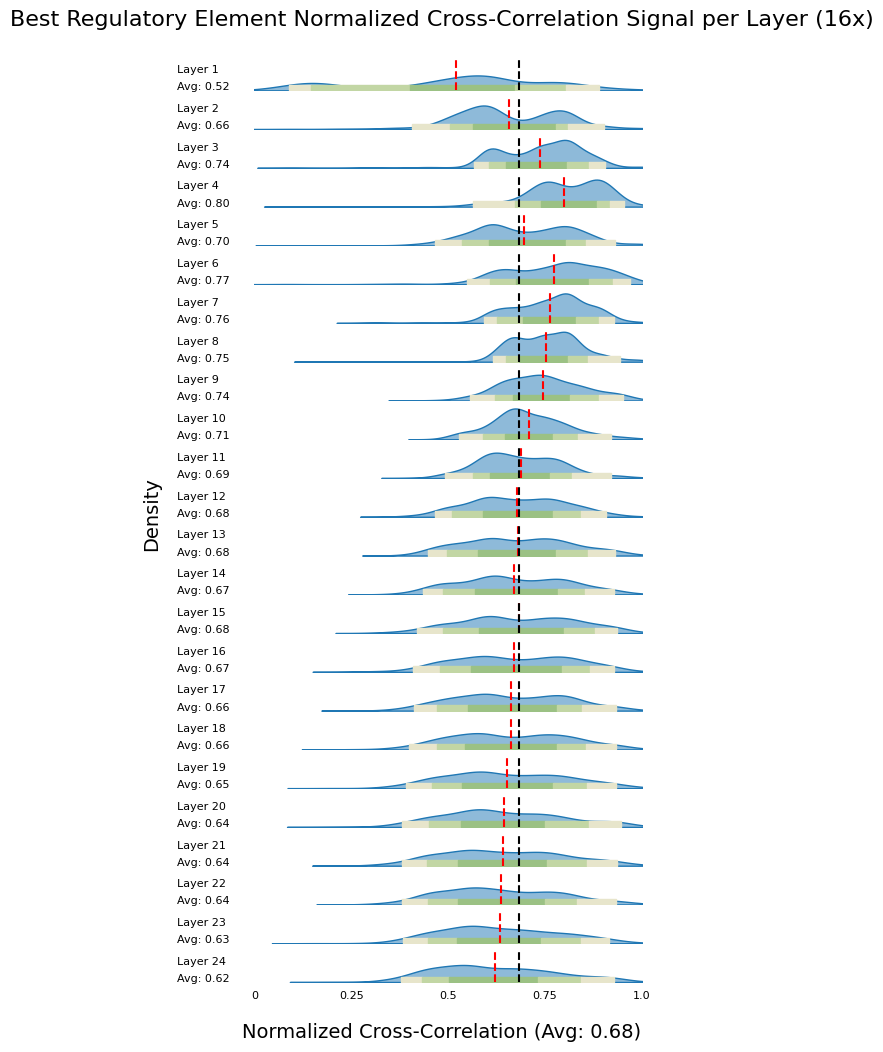

In [8]:
# ef16
ridgeline_data = []
for layer in directory["ef16"]:
    blob = bucket.blob(f"regelannotations/ef16/{layer}")
    csv_file = blob.open("r")
    df = pd.read_csv(csv_file)
    ridgeline_data.append(df["f1_avglag(normxcorr)"])


# global mean
global_mean = pd.concat(ridgeline_data).mean()


# Plotting
fig, axs = plt.subplots(nrows=len(ridgeline_data), ncols=1, figsize=(5, 12), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle(
    "Best Regulatory Element Normalized Cross-Correlation Signal per Layer (16x)",
    fontsize=16,
    #fontproperties=fira_sans_semibold,
    y = 0.92
)
fig.supxlabel(
    f"Normalized Cross-Correlation (Avg: {global_mean:.2f})",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    y = 0.06
)
fig.supylabel(
    "Density",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    x = -0.1  # move y-label slightly left
)

# construct the ridgeline plot
for i, data in enumerate(ridgeline_data):
    sns.kdeplot(data, ax=axs[i], fill=True, alpha=0.5)

    # relative averages
    mean = data.mean()
    axs[i].axvline(mean, color='red', linestyle='--', label='Mean')
    axs[i].axvline(global_mean, color="black", linestyle='--', label='Global Mean')

    # add some annotations
    axs[i].text(
        -0.2, 2.5,
        f"Layer {i+1}",
        ha="left",
        fontsize=8,
    )

    axs[i].text(
        -0.2, 0,
        f"Avg: {mean:.2f}",
        ha="left",
        fontsize=8,
    )

    # quantiles
    quantiles = np.percentile(data, [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        axs[i].fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            0, # max y=0
            0.8, # max y=0.8
            color=colors[j]
        )

    # x axis scale for last ax
    if i == 23:
        values = [0, 0.25, 0.5, 0.75, 1.0]
        for value in values:
            axs[i].text(
                value, -2.5,
                f'{value}',
                ha='center',
                fontsize=8
            )

    axs[i].set_xlim(0, 1)
    axs[i].set_axis_off()

plt.show()

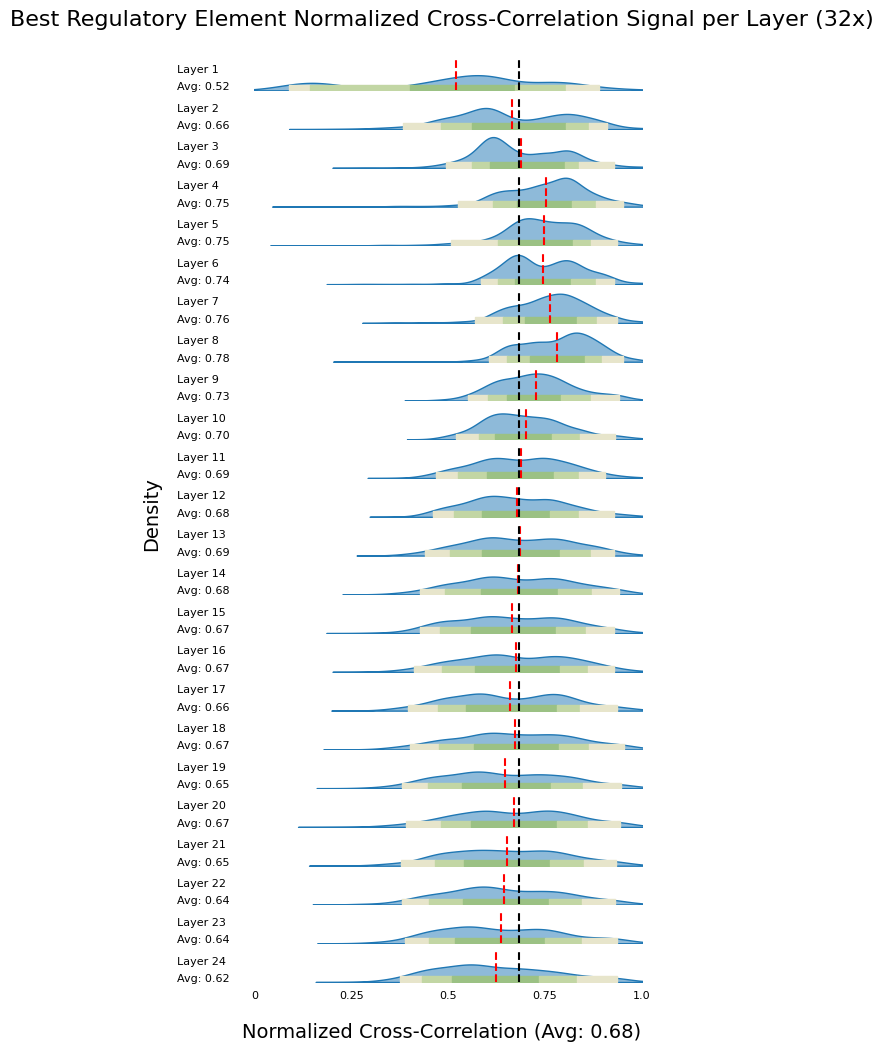

In [9]:
# ef32
ridgeline_data = []
for layer in directory["ef32"]:
    blob = bucket.blob(f"regelannotations/ef32/{layer}")
    csv_file = blob.open("r")
    df = pd.read_csv(csv_file)
    ridgeline_data.append(df["f1_avglag(normxcorr)"])


# global mean
global_mean = pd.concat(ridgeline_data).mean()


# Plotting
fig, axs = plt.subplots(nrows=len(ridgeline_data), ncols=1, figsize=(5, 12), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle(
    "Best Regulatory Element Normalized Cross-Correlation Signal per Layer (32x)",
    fontsize=16,
    #fontproperties=fira_sans_semibold,
    y = 0.92
)
fig.supxlabel(
    f"Normalized Cross-Correlation (Avg: {global_mean:.2f})",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    y = 0.06
)
fig.supylabel(
    "Density",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    x = -0.1  # move y-label slightly left
)

# construct the ridgeline plot
for i, data in enumerate(ridgeline_data):
    sns.kdeplot(data, ax=axs[i], fill=True, alpha=0.5)

    # relative averages
    mean = data.mean()
    axs[i].axvline(mean, color='red', linestyle='--', label='Mean')
    axs[i].axvline(global_mean, color="black", linestyle='--', label='Global Mean')

    # add some annotations
    axs[i].text(
        -0.2, 2.5,
        f"Layer {i+1}",
        ha="left",
        fontsize=8,
    )

    axs[i].text(
        -0.2, 0,
        f"Avg: {mean:.2f}",
        ha="left",
        fontsize=8,
    )

    # quantiles
    quantiles = np.percentile(data, [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        axs[i].fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            0, # max y=0
            0.8, # max y=0.8
            color=colors[j]
        )

    # x axis scale for last ax
    if i == 23:
        values = [0, 0.25, 0.5, 0.75, 1.0]
        for value in values:
            axs[i].text(
                value, -2.5,
                f'{value}',
                ha='center',
                fontsize=8
            )

    axs[i].set_xlim(0, 1)
    axs[i].set_axis_off()

plt.show()

# Common Feature Sets

Presumably, the model will be better able to identify and track certain types of features than other types of features. Protein binding sites, for example, have motifs that directly interact with a specific protein and necessarily embed that information as highly conserved motifs which are important to that interaction. By contrast, leader sequences which manfiest their regulatory role during translation should be less obvious to a transformer language model trained on genomic sequences alone since the functional interaction occurs downstream from the omics domain that it was trained in.

To assess preferential feature extraction, we examine the sets of features that activate for different types of regulatory elements, the strength of those correlations, and attempt to identify common features across the 11 main categories labelled in the NCBI regulatory element track set.

In [10]:
# creating the labels for the tracks
def create_labels(track_name:str) -> str:

    regelement_type = None

    track_name = track_name.lower().strip()

    # has suffix
    if "_leader_sequence" in track_name:
        regelement_type = "leader_sequence"
    # has prefix
    elif ":" in track_name:
        track_name = track_name.split(":")
        regelement_type = track_name[0].strip()
    else:
        regelement_type = "other"

    return regelement_type

# sanity check
for layer in directory["ef32"]:
    blob = bucket.blob(f"regelannotations/ef32/{layer}")
    csv_file = blob.open("r")
    df = pd.read_csv(csv_file)

    # create labels
    df["label"] = df["track_name"].apply(create_labels)

    # check unique labels
    unique_labels = df["label"].unique()
    print(f"Unique labels for {layer}: {unique_labels}")

Unique labels for layer_0: ['other' 'leader_sequence' 'line' 'sine' 'misc_recomb' 'misc_structure'
 'non-ltr_retrotransposon' 'protein_bind' 'rep_origin' 'retrotransposon'
 'stem_loop']
Unique labels for layer_1: ['other' 'leader_sequence' 'line' 'sine' 'misc_recomb' 'misc_structure'
 'non-ltr_retrotransposon' 'protein_bind' 'rep_origin' 'retrotransposon'
 'stem_loop']
Unique labels for layer_2: ['other' 'leader_sequence' 'line' 'sine' 'misc_recomb' 'misc_structure'
 'non-ltr_retrotransposon' 'protein_bind' 'rep_origin' 'retrotransposon'
 'stem_loop']
Unique labels for layer_3: ['other' 'leader_sequence' 'line' 'sine' 'misc_recomb' 'misc_structure'
 'non-ltr_retrotransposon' 'protein_bind' 'rep_origin' 'retrotransposon'
 'stem_loop']
Unique labels for layer_4: ['other' 'leader_sequence' 'line' 'sine' 'misc_recomb' 'misc_structure'
 'non-ltr_retrotransposon' 'protein_bind' 'rep_origin' 'retrotransposon'
 'stem_loop']
Unique labels for layer_5: ['other' 'leader_sequence' 'line' 'sine' 'm

In [11]:
# find feature sets
feature_sets = {}

for size in directory.keys():
    feature_sets[size] = {}
    for layer in directory[size]:
        blob = bucket.blob(f"regelannotations/{size}/{layer}")
        csv_file = blob.open("r")
        df = pd.read_csv(csv_file)

        if layer not in feature_sets[size]:
            feature_sets[size][layer] = {}

        # create labels
        df["label"] = df["track_name"].apply(create_labels)

        # group by label and extract feature id numbers
        groups = df.groupby("label")
        feature_ids = ["f1_idx", "f2_idx", "f3_idx", "f4_idx", "f5_idx"]

        for category in groups:
            features = pd.concat([category[1][fid] for fid in feature_ids], axis=0)
            category_size = len(category[1])

            category_frequencies = {}
            for f, count in features.value_counts().items():
                category_frequencies[f] = count / category_size

            feature_sets[size][layer][category[0]] = {
                "category_size": category_size,
                "counts": features.value_counts().to_dict(),
                "frequency_per_sample": category_frequencies
            }

import pprint
print("Feature sets by size and category:")
pprint.pprint(feature_sets, depth=3)

Feature sets by size and category:
{'ef16': {'layer_0': {'leader_sequence': {...},
                      'line': {...},
                      'misc_recomb': {...},
                      'misc_structure': {...},
                      'non-ltr_retrotransposon': {...},
                      'other': {...},
                      'protein_bind': {...},
                      'rep_origin': {...},
                      'retrotransposon': {...},
                      'sine': {...},
                      'stem_loop': {...}},
          'layer_1': {'leader_sequence': {...},
                      'line': {...},
                      'misc_recomb': {...},
                      'misc_structure': {...},
                      'non-ltr_retrotransposon': {...},
                      'other': {...},
                      'protein_bind': {...},
                      'rep_origin': {...},
                      'retrotransposon': {...},
                      'sine': {...},
                      'stem_loop': {

In [12]:
# aggregate the top 10 frequent features for a given category across all layers and expansions
# CORRECTION: some categories have only 9 unique features in their 5 best correlated features across the given parameters
aggregate_frequencies = {}
for size, layer in feature_sets.items():
    for layer_name, data in layer.items():
        for category, values in data.items():
            if category not in aggregate_frequencies.keys():
                aggregate_frequencies[category] = []

            # sort the frequencies high to low
            sorted_frequencies = sorted(values["frequency_per_sample"].items(), key=lambda item: item[1], reverse=True)
            top_frequencies = [y for x, y in sorted_frequencies[:9]] 

            aggregate_frequencies[category].append(top_frequencies)

#pprint.pprint(aggregate_frequencies, depth=3)

# average the frequencies to find rates of top 5 feature reoccurrence for each category
mean_frequencies = {}
for category, frequencies in aggregate_frequencies.items():
#    print([len(f) for f in frequencies])
    frequencies = np.array(frequencies)
    mean_frequencies[category] = np.mean(frequencies, axis=0)

pprint.pprint(mean_frequencies, depth=3)

{'leader_sequence': array([0.3852657 , 0.24416264, 0.14885266, 0.08856683, 0.07246377,
       0.06239936, 0.05052335, 0.04508857, 0.04176731]),
 'line': array([0.61574074, 0.48611111, 0.40277778, 0.36111111, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333]),
 'misc_recomb': array([0.39634601, 0.2559657 , 0.18167412, 0.12052573, 0.08780761,
       0.07475764, 0.05471663, 0.04912379, 0.0445563 ]),
 'misc_structure': array([0.35416667, 0.30902778, 0.27777778, 0.26041667, 0.25      ,
       0.25      , 0.25      , 0.25      , 0.25      ]),
 'non-ltr_retrotransposon': array([0.55208333, 0.44444444, 0.38888889, 0.3125    , 0.26736111,
       0.25347222, 0.25347222, 0.25      , 0.25      ]),
 'other': array([0.30116959, 0.24159357, 0.2119883 , 0.18055556, 0.16118421,
       0.14254386, 0.12755848, 0.11366959, 0.10307018]),
 'protein_bind': array([0.35449258, 0.24052347, 0.18095668, 0.14184717, 0.10664862,
       0.08238067, 0.06272563, 0.05390092, 0.04402327]),
 'rep_origin'

Text(0, 0.5, 'Best to Worst Feature Presence by Rank')

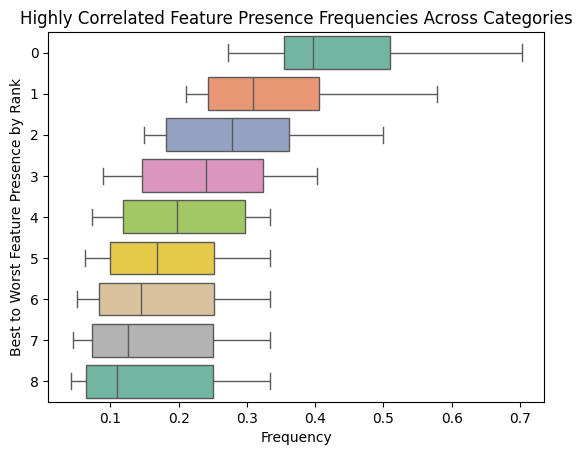

In [13]:
# visualize feature presence frequencies across categories
sns.boxplot(
    data=pd.DataFrame(mean_frequencies).T,
    orient="h",
    palette="Set2"
)
plt.title("Highly Correlated Feature Presence Frequencies Across Categories")
plt.xlabel("Frequency")
plt.ylabel("Best to Worst Feature Presence by Rank")

Text(0, 0.5, 'Regulatory Element Category')

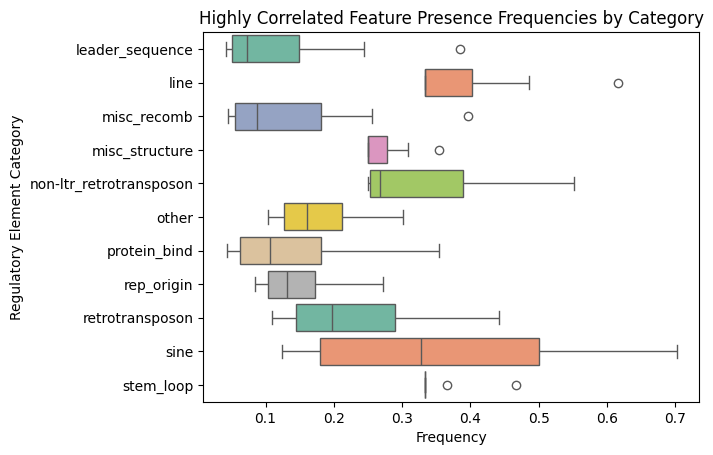

In [14]:
# performance of individual regulatory element categories
sns.boxplot(
    data=pd.DataFrame(mean_frequencies),
    orient="h",
    palette="Set2"
)
plt.title("Highly Correlated Feature Presence Frequencies by Category")
plt.xlabel("Frequency")
plt.ylabel("Regulatory Element Category")

Text(0, 0.5, 'Regulatory Element Category')

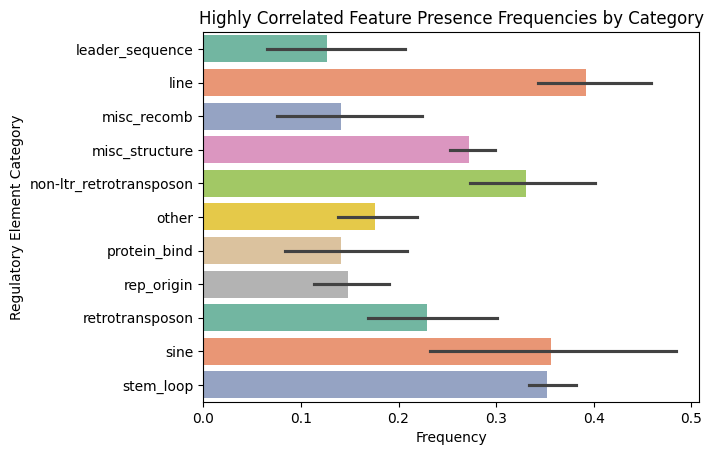

In [15]:
sns.barplot(
    data=pd.DataFrame(mean_frequencies),
    orient="h",
    palette="Set2"
)
plt.title("Highly Correlated Feature Presence Frequencies by Category")
plt.xlabel("Frequency")
plt.ylabel("Regulatory Element Category")

# Ridgeline Plots by Category

To take a deeper look at how some types of regulatory elements are picked up by the model, we construct some ridgeline plots for this as well.

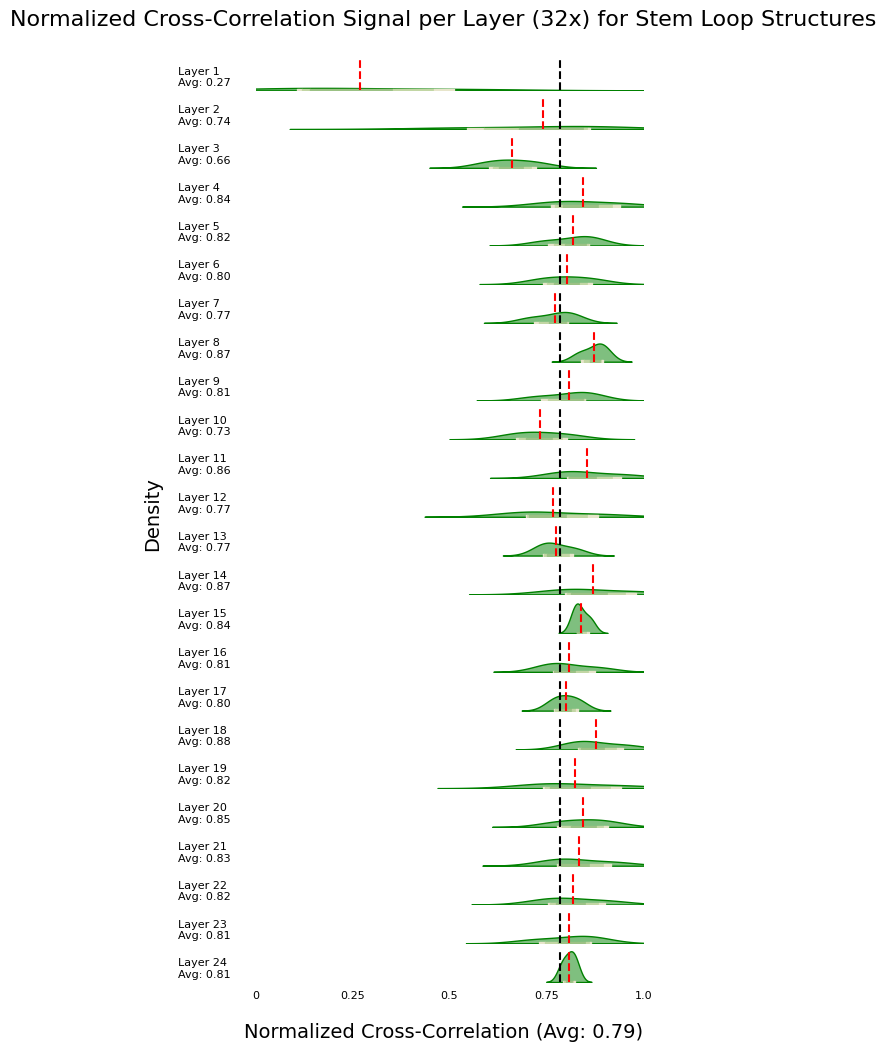

In [20]:
# ef32 - stem loop NCC
ridgeline_data = []
for layer in directory["ef32"]:
    blob = bucket.blob(f"regelannotations/ef32/{layer}")
    csv_file = blob.open("r")
    df = pd.read_csv(csv_file)

    df["label"] = df["track_name"].apply(create_labels)
    df = df[df["label"] == "stem_loop"]

    ridgeline_data.append(df["f1_avglag(normxcorr)"])


# global mean
global_mean = pd.concat(ridgeline_data).mean()


# Plotting
fig, axs = plt.subplots(nrows=len(ridgeline_data), ncols=1, figsize=(5, 12), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle(
    "Normalized Cross-Correlation Signal per Layer (32x) for Stem Loop Structures",
    fontsize=16,
    #fontproperties=fira_sans_semibold,
    y = 0.92
)
fig.supxlabel(
    f"Normalized Cross-Correlation (Avg: {global_mean:.2f})",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    y = 0.06
)
fig.supylabel(
    "Density",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    x = -0.1  # move y-label slightly left
)

# construct the ridgeline plot
for i, data in enumerate(ridgeline_data):
    sns.kdeplot(data, ax=axs[i], fill=True, alpha=0.5, color="green")

    # relative averages
    mean = data.mean()
    axs[i].axvline(mean, color='red', linestyle='--', label='Mean')
    axs[i].axvline(global_mean, color="black", linestyle='--', label='Global Mean')

    # add some annotations
    axs[i].text(
        -0.2, 2.5,
        f"Layer {i+1}\nAvg: {mean:.2f}",
        ha="left",
        fontsize=8,
    )

#    axs[i].text(
#        -0.2, 0,
#        f"Avg: {mean:.2f}",
#        ha="left",
#        fontsize=8,
#    )

    # quantiles
    quantiles = np.percentile(data, [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        axs[i].fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            0, # max y=0
            0.8, # max y=0.8
            color=colors[j]
        )

    # x axis scale for last ax
    if i == 23:
        values = [0, 0.25, 0.5, 0.75, 1.0]
        for value in values:
            axs[i].text(
                value, -10.5,
                f'{value}',
                ha='center',
                fontsize=8
            )

    axs[i].set_xlim(0, 1)
    axs[i].set_axis_off()

plt.show()

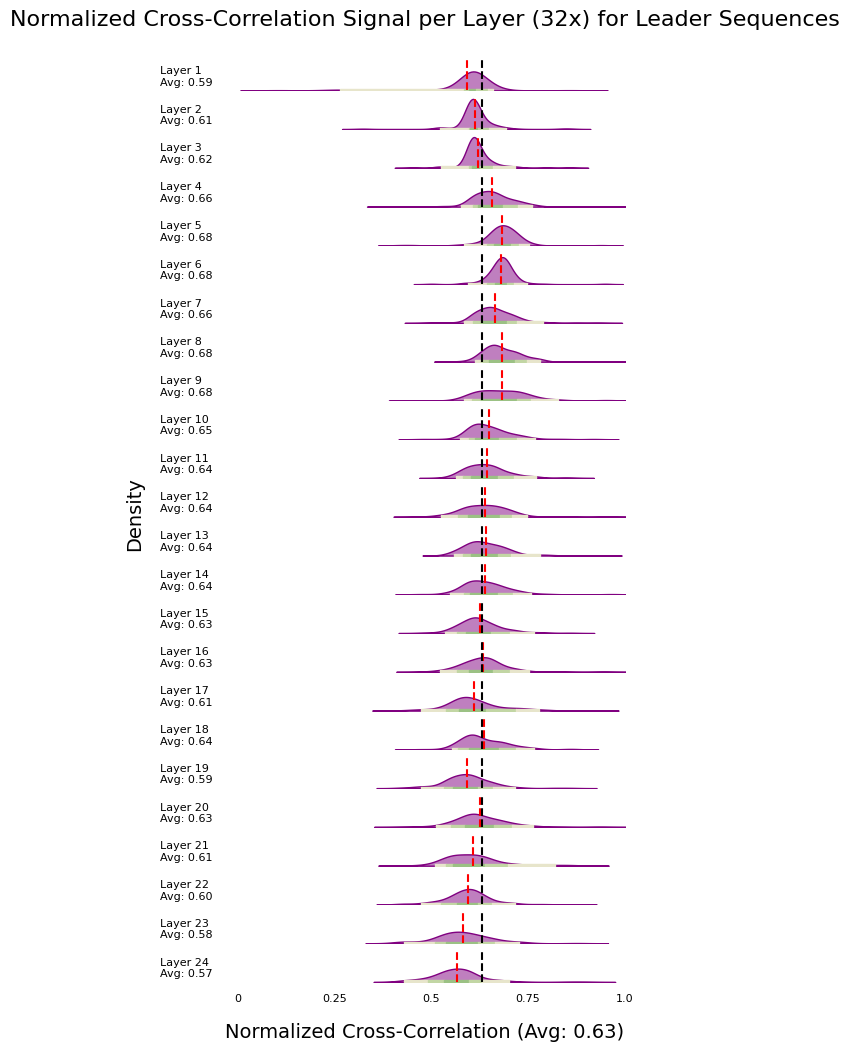

In [ ]:
# ef32 - leader sequence NCC
ridgeline_data = []
for layer in directory["ef32"]:
    blob = bucket.blob(f"regelannotations/ef32/{layer}")
    csv_file = blob.open("r")
    df = pd.read_csv(csv_file)

    df["label"] = df["track_name"].apply(create_labels)
    df = df[df["label"] == "leader_sequence"]

    ridgeline_data.append(df["f1_avglag(normxcorr)"])


# global mean
global_mean = pd.concat(ridgeline_data).mean()


# Plotting
fig, axs = plt.subplots(nrows=len(ridgeline_data), ncols=1, figsize=(5, 12), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle(
    "Normalized Cross-Correlation Signal per Layer (32x) for Leader Sequences",
    fontsize=16,
    #fontproperties=fira_sans_semibold,
    y = 0.92
)
fig.supxlabel(
    f"Normalized Cross-Correlation (Avg: {global_mean:.2f})",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    y = 0.06
)
fig.supylabel(
    "Density",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    x = -0.1  # move y-label slightly left
)

# construct the ridgeline plot
for i, data in enumerate(ridgeline_data):
    sns.kdeplot(data, ax=axs[i], fill=True, alpha=0.5, color="purple")

    # relative averages
    mean = data.mean()
    axs[i].axvline(mean, color='red', linestyle='--', label='Mean')
    axs[i].axvline(global_mean, color="black", linestyle='--', label='Global Mean')

    # add some annotations
    axs[i].text(
        -0.2, 2.5,
        f"Layer {i+1}\nAvg: {mean:.2f}",
        ha="left",
        fontsize=8,
    )

#    axs[i].text(
#        -0.2, 0,
#        f"Avg: {mean:.2f}",
#        ha="left",
#        fontsize=8,
#    )

    # quantiles
    quantiles = np.percentile(data, [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        axs[i].fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            0, # max y=0
            0.8, # max y=0.8
            color=colors[j]
        )

    # x axis scale for last ax
    if i == 23:
        values = [0, 0.25, 0.5, 0.75, 1.0]
        for value in values:
            axs[i].text(
                value, -10.5,
                f'{value}',
                ha='center',
                fontsize=8
            )

    axs[i].set_xlim(0, 1)
    axs[i].set_axis_off()

plt.show()

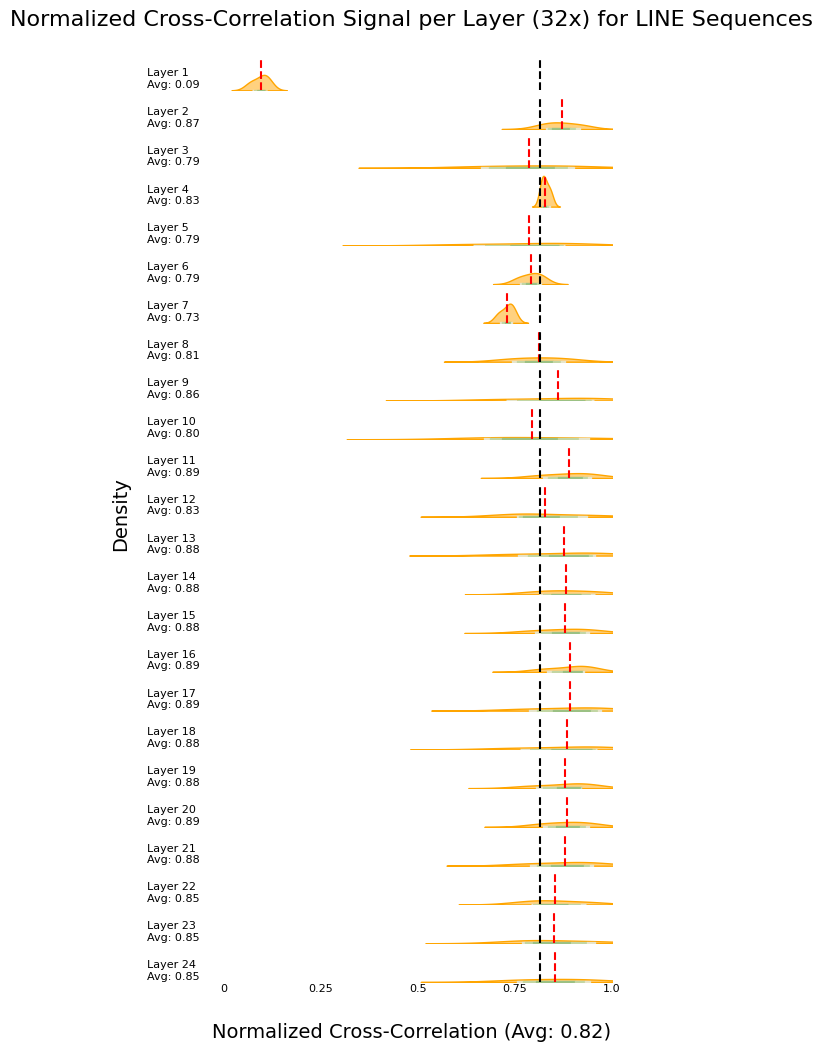

In [25]:
# ef32 - LINE NCC
ridgeline_data = []
for layer in directory["ef32"]:
    blob = bucket.blob(f"regelannotations/ef32/{layer}")
    csv_file = blob.open("r")
    df = pd.read_csv(csv_file)

    df["label"] = df["track_name"].apply(create_labels)
    df = df[df["label"] == "line"]

    ridgeline_data.append(df["f1_avglag(normxcorr)"])


# global mean
global_mean = pd.concat(ridgeline_data).mean()


# Plotting
fig, axs = plt.subplots(nrows=len(ridgeline_data), ncols=1, figsize=(5, 12), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle(
    "Normalized Cross-Correlation Signal per Layer (32x) for LINE Sequences",
    fontsize=16,
    #fontproperties=fira_sans_semibold,
    y = 0.92
)
fig.supxlabel(
    f"Normalized Cross-Correlation (Avg: {global_mean:.2f})",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    y = 0.06
)
fig.supylabel(
    "Density",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    x = -0.1  # move y-label slightly left
)

# construct the ridgeline plot
for i, data in enumerate(ridgeline_data):
    sns.kdeplot(data, ax=axs[i], fill=True, alpha=0.5, color="orange")

    # relative averages
    mean = data.mean()
    axs[i].axvline(mean, color='red', linestyle='--', label='Mean')
    axs[i].axvline(global_mean, color="black", linestyle='--', label='Global Mean')

    # add some annotations
    axs[i].text(
        -0.2, 2.5,
        f"Layer {i+1}\nAvg: {mean:.2f}",
        ha="left",
        fontsize=8,
    )

#    axs[i].text(
#        -0.2, 0,
#        f"Avg: {mean:.2f}",
#        ha="left",
#        fontsize=8,
#    )

    # quantiles
    quantiles = np.percentile(data, [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        axs[i].fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            0, # max y=0
            0.8, # max y=0.8
            color=colors[j]
        )

    # x axis scale for last ax
    if i == 23:
        values = [0, 0.25, 0.5, 0.75, 1.0]
        for value in values:
            axs[i].text(
                value, -10.5,
                f'{value}',
                ha='center',
                fontsize=8
            )

    axs[i].set_xlim(0, 1)
    axs[i].set_axis_off()

plt.show()

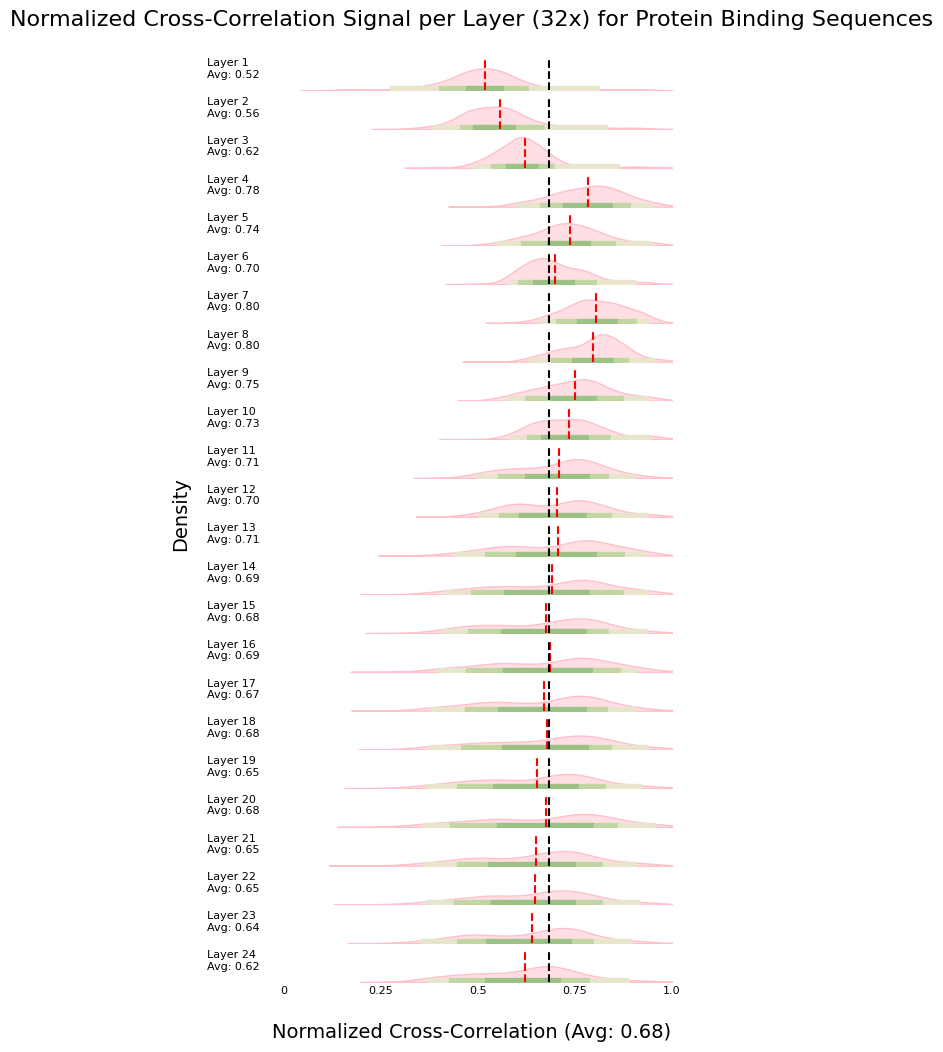

In [27]:
# ef32 - protein binding NCC
ridgeline_data = []
for layer in directory["ef32"]:
    blob = bucket.blob(f"regelannotations/ef32/{layer}")
    csv_file = blob.open("r")
    df = pd.read_csv(csv_file)

    df["label"] = df["track_name"].apply(create_labels)
    df = df[df["label"] == "protein_bind"]

    ridgeline_data.append(df["f1_avglag(normxcorr)"])


# global mean
global_mean = pd.concat(ridgeline_data).mean()


# Plotting
fig, axs = plt.subplots(nrows=len(ridgeline_data), ncols=1, figsize=(5, 12), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle(
    "Normalized Cross-Correlation Signal per Layer (32x) for Protein Binding Sequences",
    fontsize=16,
    #fontproperties=fira_sans_semibold,
    y = 0.92
)
fig.supxlabel(
    f"Normalized Cross-Correlation (Avg: {global_mean:.2f})",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    y = 0.06
)
fig.supylabel(
    "Density",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    x = -0.1  # move y-label slightly left
)

# construct the ridgeline plot
for i, data in enumerate(ridgeline_data):
    sns.kdeplot(data, ax=axs[i], fill=True, alpha=0.5, color="pink")

    # relative averages
    mean = data.mean()
    axs[i].axvline(mean, color='red', linestyle='--', label='Mean')
    axs[i].axvline(global_mean, color="black", linestyle='--', label='Global Mean')

    # add some annotations
    axs[i].text(
        -0.2, 2.5,
        f"Layer {i+1}\nAvg: {mean:.2f}",
        ha="left",
        fontsize=8,
    )

#    axs[i].text(
#        -0.2, 0,
#        f"Avg: {mean:.2f}",
#        ha="left",
#        fontsize=8,
#    )

    # quantiles
    quantiles = np.percentile(data, [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        axs[i].fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            0, # max y=0
            0.8, # max y=0.8
            color=colors[j]
        )

    # x axis scale for last ax
    if i == 23:
        values = [0, 0.25, 0.5, 0.75, 1.0]
        for value in values:
            axs[i].text(
                value, -2.5,
                f'{value}',
                ha='center',
                fontsize=8
            )

    axs[i].set_xlim(0, 1)
    axs[i].set_axis_off()

plt.show()

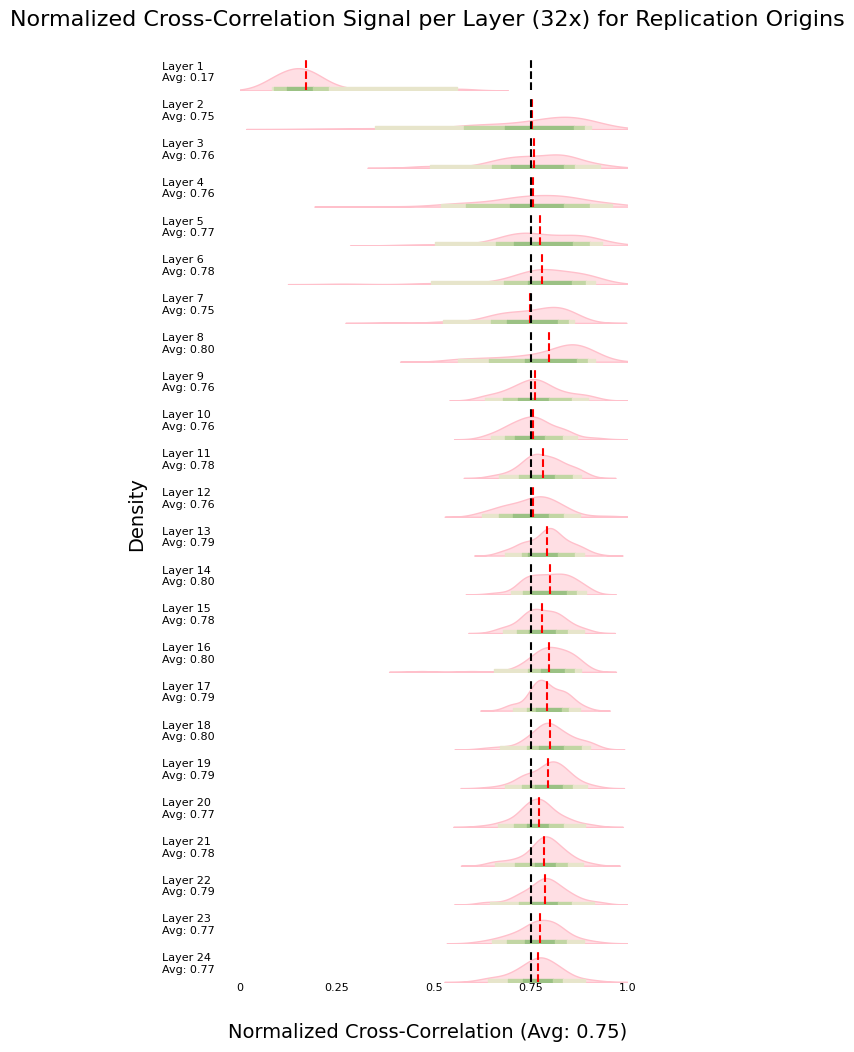

In [28]:
# ef32 - replication origin NCC
ridgeline_data = []
for layer in directory["ef32"]:
    blob = bucket.blob(f"regelannotations/ef32/{layer}")
    csv_file = blob.open("r")
    df = pd.read_csv(csv_file)

    df["label"] = df["track_name"].apply(create_labels)
    df = df[df["label"] == "rep_origin"]

    ridgeline_data.append(df["f1_avglag(normxcorr)"])


# global mean
global_mean = pd.concat(ridgeline_data).mean()


# Plotting
fig, axs = plt.subplots(nrows=len(ridgeline_data), ncols=1, figsize=(5, 12), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle(
    "Normalized Cross-Correlation Signal per Layer (32x) for Replication Origins",
    fontsize=16,
    #fontproperties=fira_sans_semibold,
    y = 0.92
)
fig.supxlabel(
    f"Normalized Cross-Correlation (Avg: {global_mean:.2f})",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    y = 0.06
)
fig.supylabel(
    "Density",
    fontsize=14,
    #fontproperties=fira_sans_regular,
    x = -0.1  # move y-label slightly left
)

# construct the ridgeline plot
for i, data in enumerate(ridgeline_data):
    sns.kdeplot(data, ax=axs[i], fill=True, alpha=0.5, color="pink")

    # relative averages
    mean = data.mean()
    axs[i].axvline(mean, color='red', linestyle='--', label='Mean')
    axs[i].axvline(global_mean, color="black", linestyle='--', label='Global Mean')

    # add some annotations
    axs[i].text(
        -0.2, 2.5,
        f"Layer {i+1}\nAvg: {mean:.2f}",
        ha="left",
        fontsize=8,
    )

#    axs[i].text(
#        -0.2, 0,
#        f"Avg: {mean:.2f}",
#        ha="left",
#        fontsize=8,
#    )

    # quantiles
    quantiles = np.percentile(data, [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        axs[i].fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            0, # max y=0
            0.8, # max y=0.8
            color=colors[j]
        )

    # x axis scale for last ax
    if i == 23:
        values = [0, 0.25, 0.5, 0.75, 1.0]
        for value in values:
            axs[i].text(
                value, -2.5,
                f'{value}',
                ha='center',
                fontsize=8
            )

    axs[i].set_xlim(0, 1)
    axs[i].set_axis_off()

plt.show()